In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb

import sys
sys.path.append('../../../src/')
from build_model import densenet161_yichen
from train_functions import train_epochs
from dataset_functions import hdf5_dataset, list_to_dict, viz_dataloader
from visualization_functions import show_images

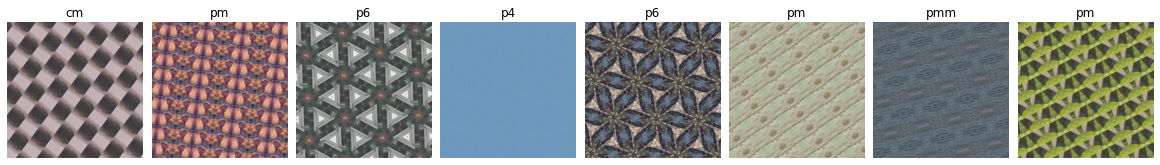

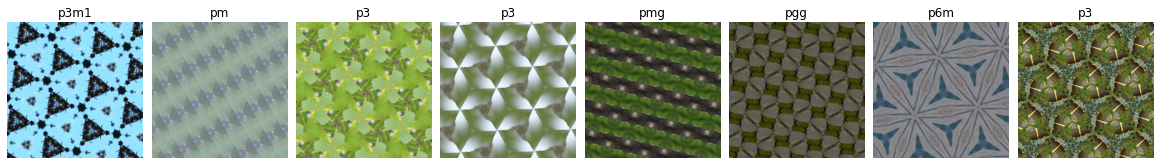

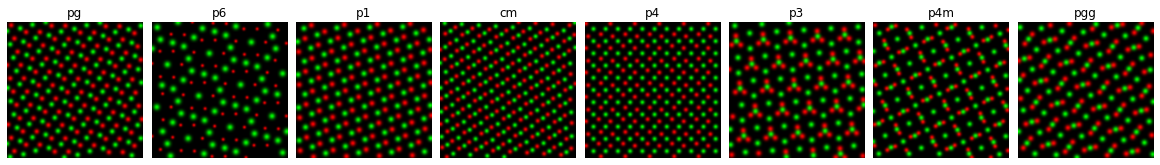

In [2]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet train
train_ds = hdf5_dataset('/scratch/yichen/imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=110, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter)

# imagenet valid
valid_ds = hdf5_dataset('/scratch/yichen/imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=110, shuffle=True, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter)

# atom test
test_ds = hdf5_dataset('/scratch/yichen/atom_v4_rot_2m_unchunked_fixed.h5', folder='test', transform=transforms.ToTensor())
test_dl = DataLoader(test_ds, batch_size=110, shuffle=True, num_workers=4)
viz_dataloader(test_dl, label_converter=label_converter)

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
# print(os.environ["CUDA_VISIBLE_DEVICES"])
# device = torch.device('cuda')
device = torch.device('cuda:3')

In [4]:
model = densenet161_yichen(in_channels=3, n_classes=17, pretrained=False)
# model = nn.DataParallel(model)
# print(model.to(device))
print(model(torch.randn(2, 3, 256, 256)).shape)

/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/yichen/anaconda3/envs/gyc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([2, 17])


In [5]:
config = {
    'dataset': '10 million datasets',
    'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
    'optimizer': 'Adam',
    'scheduler': 'OneCycleLR',
}

NAME = '01122024-benchmark-DenseNet161-v4_10m'

# train

In [6]:
wandb.login()

proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, save_code=True, config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin


In [7]:
lr = 1e-3
start = 0
epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, 
                            steps_per_epoch=len(train_dl))

history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, test_dl,
                       epochs=epochs, start=start, scheduler=scheduler, model_name=NAME, 
                       model_dir='../../../saved_models/', tracking=True)

Epoch: 1/20


100%|██████████| 90910/90910 [11:54:16<00:00,  2.12it/s]  


Training: Loss: 0.3242, Accuracy: 89.4610%, Time: 714.2711mins


100%|██████████| 18182/18182 [54:11<00:00,  5.59it/s]


Validation : Loss : 0.0405, Accuracy: 98.7121%, Time: 54.19mins


100%|██████████| 17023/17023 [50:41<00:00,  5.60it/s]


Validation : Loss : 3.9190, Accuracy: 49.3486%, Time: 50.69mins
Epoch: 2/20


100%|██████████| 90910/90910 [11:53:35<00:00,  2.12it/s]  


Training: Loss: 0.0374, Accuracy: 98.9238%, Time: 713.5879mins


100%|██████████| 18182/18182 [55:00<00:00,  5.51it/s]


Validation : Loss : 0.0224, Accuracy: 99.3087%, Time: 55.01mins


100%|██████████| 17023/17023 [52:02<00:00,  5.45it/s]


Validation : Loss : 4.3393, Accuracy: 47.0386%, Time: 52.04mins
Epoch: 3/20


  9%|▉         | 8413/90910 [1:05:32<10:33:50,  2.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▍       | 22680/90910 [2:56:31<11:26:30,  1.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|████      | 36593/90910 [4:45:03<7:02:35,  2.14it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


Training: Loss: 0.0195, Accuracy: 99.4540%, Time: 709.6743mins


100%|██████████| 18182/18182 [54:53<00:00,  5.52it/s]


Validation : Loss : 0.0129, Accuracy: 99.5999%, Time: 54.90mins


100%|██████████| 17023/17023 [51:31<00:00,  5.51it/s]


Validation : Loss : 4.5157, Accuracy: 49.1304%, Time: 51.53mins
Epoch: 4/20


100%|██████████| 90910/90910 [11:50:54<00:00,  2.13it/s]  


Training: Loss: 0.0127, Accuracy: 99.6497%, Time: 710.9157mins


100%|██████████| 18182/18182 [55:12<00:00,  5.49it/s]


Validation : Loss : 0.0086, Accuracy: 99.7405%, Time: 55.21mins


100%|██████████| 17023/17023 [51:38<00:00,  5.49it/s]


Validation : Loss : 4.1690, Accuracy: 50.3887%, Time: 51.65mins
Epoch: 5/20


 91%|█████████ | 82660/90910 [10:46:59<1:47:27,  1.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|██▉       | 5431/18182 [16:39<39:09,  5.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 18182/18182 [55:28<00:00,  5.46it/s]


Validation : Loss : 0.0069, Accuracy: 99.7950%, Time: 55.47mins


 10%|▉         | 1677/17023 [05:08<47:08,  5.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████ | 15487/17023 [47:15<04:43,  5.42it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 12774/90910 [1:39:58<10:02:16,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteboo

Training: Loss: 0.0077, Accuracy: 99.7861%, Time: 709.7809mins


100%|██████████| 18182/18182 [55:20<00:00,  5.48it/s]


Validation : Loss : 0.0056, Accuracy: 99.8308%, Time: 55.34mins


100%|██████████| 17023/17023 [51:53<00:00,  5.47it/s]


Validation : Loss : 4.1930, Accuracy: 49.4888%, Time: 51.89mins
Epoch: 7/20


100%|██████████| 90910/90910 [11:52:24<00:00,  2.13it/s]  


Training: Loss: 0.0060, Accuracy: 99.8296%, Time: 712.4017mins


100%|██████████| 18182/18182 [55:36<00:00,  5.45it/s]


Validation : Loss : 0.0041, Accuracy: 99.8715%, Time: 55.61mins


100%|██████████| 17023/17023 [52:01<00:00,  5.45it/s]


Validation : Loss : 4.1480, Accuracy: 51.6908%, Time: 52.02mins
Epoch: 8/20


 49%|████▉     | 44440/90910 [5:48:26<6:02:50,  2.13it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 65%|██████▍   | 58743/90910 [7:40:45<4:08:39,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 80%|████████  | 73006/90910 [9:32:37<2:17:39,  2.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`

Validation : Loss : 3.9181, Accuracy: 52.5195%, Time: 52.01mins
Epoch: 9/20


  2%|▏         | 1704/90910 [13:27<11:27:26,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 3563/90910 [28:05<11:12:48,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 15741/90910 [2:03:45<9:40:24,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--No

Validation : Loss : 4.9920, Accuracy: 47.9160%, Time: 52.29mins
Epoch: 10/20


  2%|▏         | 1719/90910 [13:38<11:50:53,  2.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▎        | 12368/90910 [1:37:17<10:04:29,  2.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 15609/90910 [2:02:32<9:40:41,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`-

 30%|██▉       | 27035/90910 [3:32:09<8:12:38,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 37859/90910 [4:57:28<6:47:55,  2.17it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 40980/90910 [5:22:02<6:26:02,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

Training: Loss: 0.0028, Accuracy: 99.9147%, Time: 711.5417mins


100%|██████████| 18182/18182 [55:53<00:00,  5.42it/s]


Validation : Loss : 0.0028, Accuracy: 99.9078%, Time: 55.90mins


100%|██████████| 17023/17023 [52:29<00:00,  5.41it/s]


Validation : Loss : 4.9224, Accuracy: 51.5602%, Time: 52.48mins
Epoch: 13/20


100%|██████████| 90910/90910 [11:51:13<00:00,  2.13it/s]  


Training: Loss: 0.0024, Accuracy: 99.9237%, Time: 711.2283mins


100%|██████████| 18182/18182 [55:46<00:00,  5.43it/s]


Validation : Loss : 0.0025, Accuracy: 99.9176%, Time: 55.77mins


100%|██████████| 17023/17023 [51:44<00:00,  5.48it/s]


Validation : Loss : 4.6907, Accuracy: 52.7059%, Time: 51.74mins
Epoch: 14/20


 51%|█████     | 46114/90910 [6:01:07<5:46:09,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 66%|██████▌   | 60198/90910 [7:51:33<3:55:57,  2.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 74327/90910 [9:42:02<2:08:02,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`

Validation : Loss : 5.7367, Accuracy: 53.0280%, Time: 52.40mins
Epoch: 15/20


  3%|▎         | 2435/90910 [19:02<11:22:19,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 16%|█▋        | 14861/90910 [1:55:54<12:34:21,  1.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 16529/90910 [2:08:53<9:32:49,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`-

Validation : Loss : 5.6548, Accuracy: 52.4774%, Time: 52.55mins
Epoch: 16/20


  1%|▏         | 1352/90910 [10:40<15:33:40,  1.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 90910/90910 [11:49:52<00:00,  2.13it/s]  


Training: Loss: 0.0016, Accuracy: 99.9471%, Time: 709.8729mins


100%|██████████| 18182/18182 [55:57<00:00,  5.42it/s]


Validation : Loss : 0.0024, Accuracy: 99.9286%, Time: 55.96mins


100%|██████████| 17023/17023 [52:21<00:00,  5.42it/s]


Validation : Loss : 5.5059, Accuracy: 52.2191%, Time: 52.36mins
Epoch: 17/20


100%|██████████| 90910/90910 [11:52:08<00:00,  2.13it/s]  


Training: Loss: 0.0014, Accuracy: 99.9527%, Time: 712.1499mins


100%|██████████| 18182/18182 [55:59<00:00,  5.41it/s]


Validation : Loss : 0.0025, Accuracy: 99.9320%, Time: 55.98mins


 28%|██▊       | 4798/17023 [14:33<37:15,  5.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 17023/17023 [51:40<00:00,  5.49it/s]


Validation : Loss : 6.2025, Accuracy: 51.9949%, Time: 51.67mins
Epoch: 18/20


  2%|▏         | 1973/90910 [15:27<11:26:18,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 15888/90910 [2:04:26<9:39:55,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 33%|███▎      | 30218/90910 [3:57:29<7:49:40,  2.15it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`-

Training: Loss: 0.0013, Accuracy: 99.9567%, Time: 713.9236mins


100%|██████████| 18182/18182 [56:02<00:00,  5.41it/s]


Validation : Loss : 0.0025, Accuracy: 99.9320%, Time: 56.05mins


100%|██████████| 17023/17023 [52:29<00:00,  5.40it/s]


Validation : Loss : 6.3464, Accuracy: 51.9059%, Time: 52.50mins
Epoch: 19/20


100%|██████████| 90910/90910 [11:52:59<00:00,  2.13it/s]  


Training: Loss: 0.0012, Accuracy: 99.9590%, Time: 712.9898mins


100%|██████████| 18182/18182 [55:50<00:00,  5.43it/s]


Validation : Loss : 0.0026, Accuracy: 99.9343%, Time: 55.84mins


100%|██████████| 17023/17023 [52:35<00:00,  5.40it/s]


Validation : Loss : 6.5156, Accuracy: 52.2286%, Time: 52.59mins
Epoch: 20/20


 77%|███████▋  | 69767/90910 [9:04:30<2:42:58,  2.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 92%|█████████▏| 84002/90910 [10:55:41<53:25,  2.16it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 38%|███▊      | 6907/18182 [21:11<34:34,  5.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--No

Validation : Loss : 0.0026, Accuracy: 99.9336%, Time: 55.88mins


 17%|█▋        | 2870/17023 [08:44<42:54,  5.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 16640/17023 [50:46<01:11,  5.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# analyze

In [13]:
from analysis_functions import confusion_matrix, plot_cm

In [10]:
# model = torch.load('')

NAME = '01122024-benchmark-DenseNet161-v4_10m'
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                    'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']                  

In [11]:
device = torch.device('cuda:3')

cm = confusion_matrix(model, train_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-train_cm.npy', cm)

100%|██████████| 90910/90910 [4:57:42<00:00,  5.09it/s]  

Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,588308.0,588239.0,588239.0,588233.0,588232.0,588231.0,588236.0,588232.0,588239.0,588237.0,588238.0,588239.0,588239.0,588224.0,588239.0,588238.0,588237.0


Accuracy for these batches: 0.9996189030487757



ImageNet Symmetry Dataset


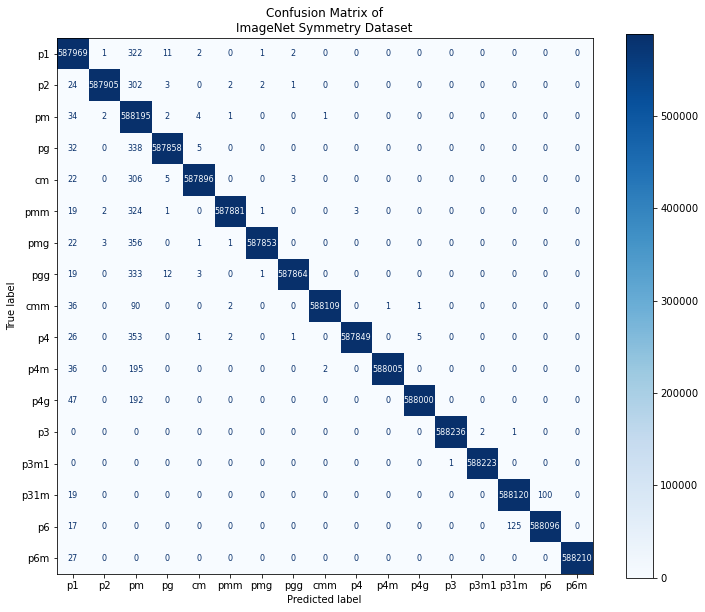

In [14]:
# cm = np.load('11172021-benchmark_atom-fpn_spatial-transfer_learning-train.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-train_cm', title='\nImageNet Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')

In [15]:
cm = confusion_matrix(model, valid_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-valid_cm.npy', cm)

100%|██████████| 18182/18182 [57:59<00:00,  5.23it/s]

Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,117670.0,117647.0,117647.0,117647.0,117646.0,117646.0,117648.0,117647.0,117647.0,117646.0,117647.0,117648.0,117647.0,117645.0,117645.0,117646.0,117647.0


Accuracy for these batches: 0.9993360053119575



ImageNet Symmetry Dataset


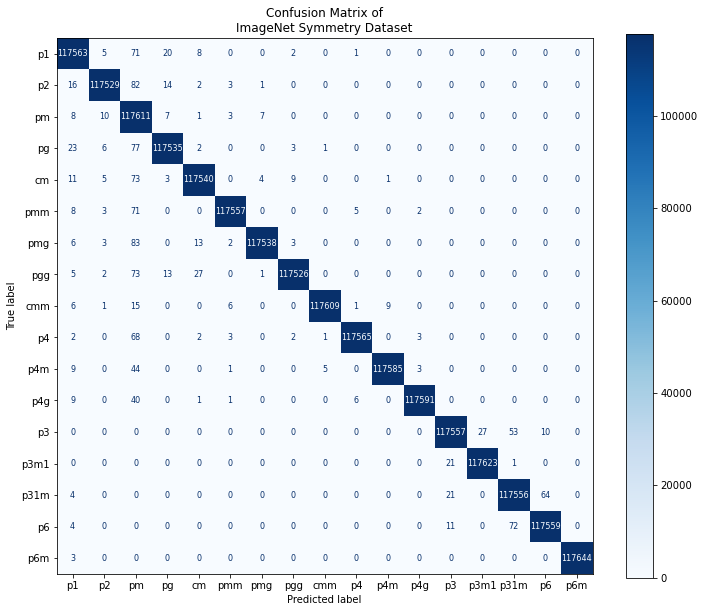

In [16]:
# cm = np.load('11172021-benchmark_imagenet-fpn_spatial-transfer_learning-valid.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-valid_cm', title='\nImageNet Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')

In [17]:
cm = confusion_matrix(model, test_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-test_cm.npy', cm)

100%|██████████| 17023/17023 [54:50<00:00,  5.17it/s]

Sum for true labels:


,p1,p2,pm,pg,cm,pmm,pmg,pgg,cmm,p4,p4m,p4g,p3,p3m1,p31m,p6,p6m
0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0,110143.0


Accuracy for these batches: 0.520377519919292



Atom Symmetry Dataset


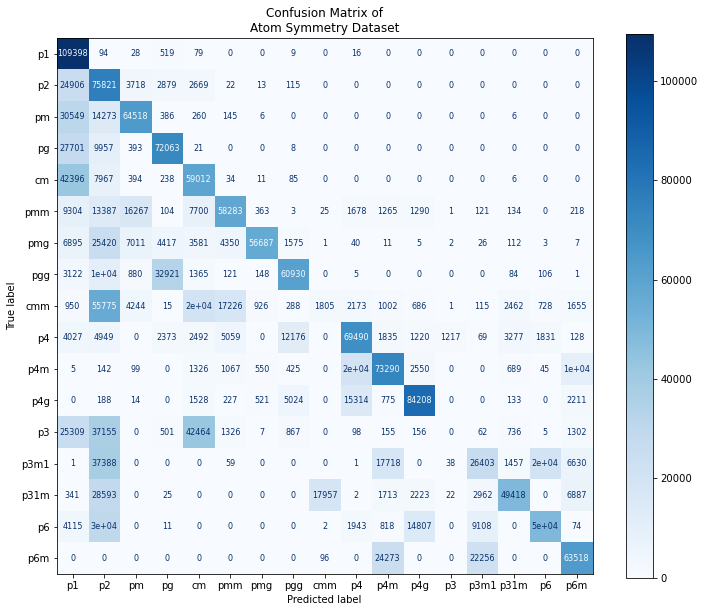

In [18]:
# cm = np.load('05232022-benchmark-resnet50_from_scratch-dataset_v3-test.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-test_cm', title='\nAtom Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')